In [50]:
%pip install --upgrade parcllabs nbformat

Note: you may need to restart the kernel to use updated packages.


In [51]:
from typing import Union
import os
import pandas as pd
import numpy as np
import plotly.express as px
from datetime import datetime
import plotly.graph_objects as go
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from parcllabs import ParclLabsClient
from parcllabs.beta.charting.styling import SIZE_CONFIG
from parcllabs.beta.ts_stats import TimeSeriesAnalysis
from parcllabs.beta.charting.utils import create_labs_logo_dict
from parcllabs.beta.charting.utils import (
    create_labs_logo_dict,
    save_figure,
    )
from parcllabs.beta.charting.styling import default_style_config as style_config


# Create a ParclLabsClient instance
client = ParclLabsClient(
    api_key=os.environ.get('PARCL_LABS_API_KEY', "<your Parcl Labs API key if not set as environment variable>"), 
    limit=1000, 
    turbo_mode=True # set turbo mode to True
)

In [52]:
# define usa market
usa_market_id = 5826765
ROOT_DIR = "../../../outputs/price_analysis_2024" # change this to the directory where you want to save the outputs



In [53]:
# get markets with pricefeed available
metros = client.search.markets.retrieve(
    sort_by='PRICEFEED_MARKET',  # Sort by total population
    sort_order='DESC',           # In descending order
    location_type='CBSA',        # Location type set to Core Based Statistical Area (CBSA)
    limit=100                    # Limit results to top 100 metros
)

In [54]:
# get the parcl_id of the metros with pricefeed available
metros_pricefeed = (metros.copy(deep=True).query('pricefeed_market==1'))
metros_pricefeed_id_list = metros_pricefeed['parcl_id'].unique().tolist()
print(len(metros_pricefeed_id_list))

50


In [55]:
# get the name of the metros
market_name = (metros_pricefeed
               .copy(deep=True)
               .loc[:,['parcl_id','name']]
               .assign(state=lambda df: df['name'].apply(lambda x: x.split(',')[-1].strip().upper().split('-')[0]))
               .assign(Metro=lambda df: df.apply(
            lambda x: f"{x['name'].split('-')[0].split(',')[0].strip()}, {x['state']}", axis=1
               ))
)

In [56]:
START_DATE = '2020-03-01'
END_DATE = '2024-12-02'

# get sales pricefeed
rental_price_feeds = client.price_feed.rental_price_feed.retrieve(
     parcl_ids=metros_pricefeed_id_list+[usa_market_id],
     start_date=START_DATE,
     end_date=END_DATE,
     limit=1000,  # expand the limit to 1000, these are daily series
     auto_paginate=True, # auto paginate to get all the data - WARNING: ~6k credits can be used in one parcl price feed. Change the START_DATE to a more recent date to reduce the number of credits used
)
rental_price_feeds.head()

data: {'parcl_id': ['2900134', '2899750', '2899621', '2900331', '2899967', '2899626', '2900174', '2899989', '2900041', '2900251', '2900475', '2900447', '2900089', '2899729', '2899748', '2899654', '2899671', '2900205', '2900192', '2899979', '2900244', '2899625', '2887280', '2899840', '2900137', '2900128', '2900049', '2900332', '2900338', '2899647', '2900213', '2900292', '2900336', '2900275', '2900079', '2900282', '2900416', '2900122', '2899841', '2900078', '2900241', '2900187', '2900417', '2899734', '2899753', '2887289', '2899845', '2900353', '2900245', '2900266', '5826765'], 'start_date': '2020-03-01', 'end_date': '2024-12-02', 'limit': 1000}, params: {'limit': 1000}


,parcl_id,date,rental_price_feed
0,5826765,2024-12-02,1.422
1,5826765,2024-12-01,1.421
2,5826765,2024-11-30,1.421
3,5826765,2024-11-29,1.419
4,5826765,2024-11-28,1.418


In [57]:
print(len(rental_price_feeds['parcl_id'].unique().tolist()))

50


In [58]:
# calculate the appreciation of the rental pricefeed for all the metros and the usa market
all_rows_rental = []
year_to_date_rows_rental = []
for pid in rental_price_feeds['parcl_id'].unique().tolist():
    prices_skew_test = rental_price_feeds.copy(deep=True).loc[rental_price_feeds['parcl_id']==pid]
    price_ts_analysis = TimeSeriesAnalysis(prices_skew_test, 'date', 'rental_price_feed', freq='M')
    price_rate_of_change_stats = price_ts_analysis.calculate_changes(change_since_date='3/1/2020')
    year_to_date_stats = price_ts_analysis.calculate_changes(change_since_date='1/1/2024')
    row = pd.json_normalize(price_rate_of_change_stats)
    ytd_row = pd.json_normalize(year_to_date_stats)
    row['parcl_id'] = pid
    ytd_row['parcl_id'] = pid
    all_rows_rental.append(row)
    year_to_date_rows_rental.append(ytd_row)

In [59]:
# concat all the rows
all_rows_rental_df = pd.concat(all_rows_rental)
year_to_date_rows_rental_df = pd.concat(year_to_date_rows_rental)

In [60]:
# prepare the data for the table, start with the 12 month change variables
data_for_table_change_rental = pd.concat(all_rows_rental)
data_for_table_change_rental = (data_for_table_change_rental.copy(deep=True)
                          .loc[:,['1_month.percent_change',
                                  '12_month.percent_change',
                                   'change_since_date.percent_change',
                                   'peak_to_current.percent_change',
                                   'parcl_id']]
                        .rename(columns={'1_month.percent_change':'MoM',
                                         '12_month.percent_change':'YoY',
                                         'peak_to_current.percent_change': 'Appreciation_since_peak',
                                         'change_since_date.percent_change':'Since March 2020'}
                                         )
                        
                        )


In [61]:
# now parse the year to date data
year_to_date_data_rental = pd.concat(year_to_date_rows_rental)
year_to_date_data_rental = (year_to_date_data_rental.copy(deep=True)
                     .loc[:,['change_since_date.percent_change',
                            'parcl_id']]
                     .rename(columns={'change_since_date.percent_change':'YTD'}
                            )
                     )

In [62]:
# merge the data for the table
final_table_data_rental = (
    data_for_table_change_rental.copy(deep=True)
    .merge(year_to_date_data_rental.copy(deep=True), how='inner', on='parcl_id')
    .merge(market_name.copy(deep=True), how='left', on='parcl_id')
    .loc[:,['parcl_id', 'Metro', 'MoM', 'YoY', 'Appreciation_since_peak', 'Since March 2020', 'YTD']]
    .assign(
            Metro=lambda x: np.where(x['Metro'].isna(), 'USA',
                   np.where(x['Metro'] == 'Louisville/Jefferson County, KY', 'Louisville, KY', x['Metro']))
        )
    .sort_values(by='YTD', ascending=False)
)
final_table_data_rental.to_csv(os.path.join(ROOT_DIR, 'final_table_data_rental_pf.csv'), index=False)

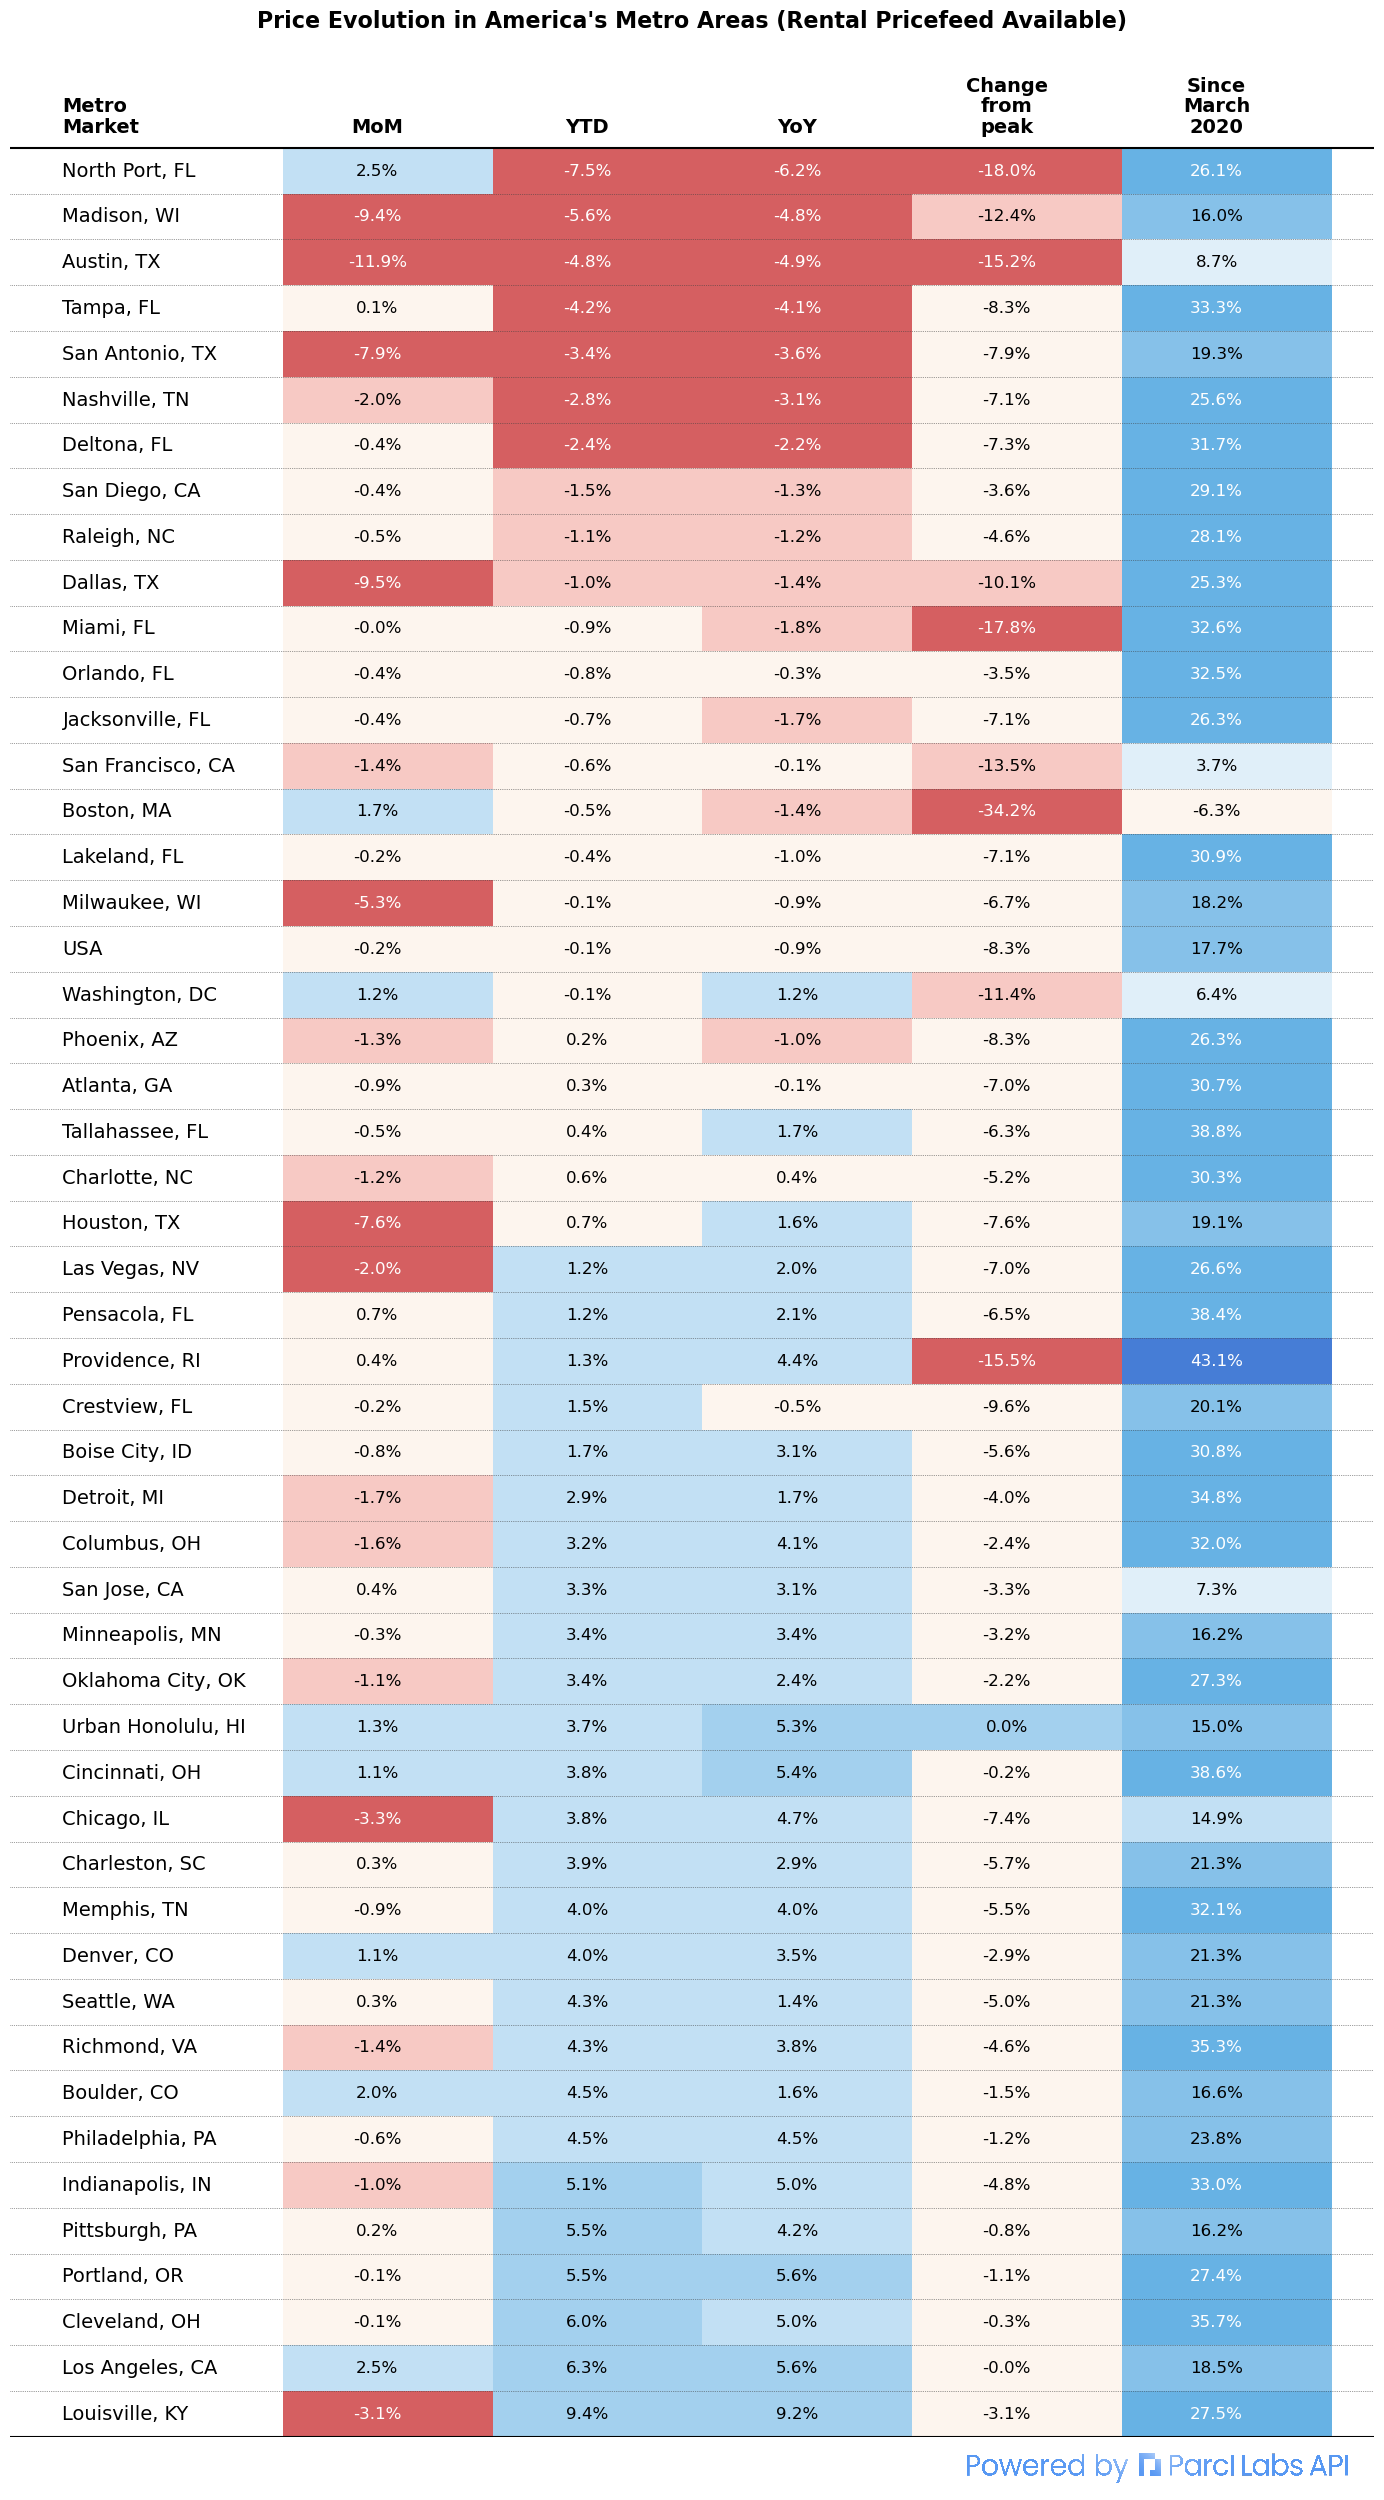

In [63]:
final_table_data_rental = final_table_data_rental.sort_values(by='YTD', ascending=False)
# Define the updated colors
def get_cell_color(val, column_type='default'):
    if pd.isna(val):
        return 'white'

    # Updated color palettes
    colors = {
        'soft_red': '#c72a2c',
        'light_red': '#F5B7B1',
        'neutral': '#FDF2E9',
        'light_blue': '#AED6F1',
        'soft_blue': '#85C1E9',
        'deep_blue': '#3498DB',
    }
    
    march_colors = {
        'light_blue': '#D6EAF8',
        'neutral': '#FDF2E9',
        'blue': '#AED6F1',
        'deep_blue': '#5DADE2',
        'dark_blue': '#3498DB',
        'darkest_blue': '#0852c9',
    }
    
    if column_type == 'since_march':
        if val < 0:
            return march_colors['neutral']
        elif val < 0.1:
            return march_colors['light_blue']
        elif val < 0.15:
            return march_colors['blue']
        elif val < 0.25:
            return march_colors['deep_blue']
        elif val < 0.4:
            return march_colors['dark_blue']
        else:
            return march_colors['darkest_blue']
    
    if column_type in ['MoM', 'YTD', 'YoY']:
        if val < -0.02:
            return colors['soft_red']
        elif val < -0.01:
            return colors['light_red']
        elif val < 0.01:
            return colors['neutral']
        elif val < 0.05:
            return colors['light_blue']
        else:
            return colors['soft_blue']
    
    elif column_type == 'appreciation':
        if val < -0.15:
            return colors['soft_red']
        elif val < -0.10:
            return colors['light_red']
        elif val < -0.05:
            return colors['neutral']
        elif val < -0.00:
            return colors['neutral']
        else:
            return colors['soft_blue']
    return 'white'

# Apply the updated font settings
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12

# Setup the figure
fig = plt.figure(figsize=(14, len(final_table_data_rental) * 0.5))
ax = plt.subplot()

# Set the plot limits
ncols = 6  # number of columns
nrows = final_table_data_rental.shape[0]
ax.set_xlim(0, ncols + 0.5)
ax.set_ylim(0, nrows + 1)

# Define positions for each column
positions = [0.25, 1.75, 2.75, 3.75, 4.75, 5.75]  # Moved columns right
column_widths = [1.3, 1.0, 1.0, 1.0, 1.0, 1.0] 

# Add background colors and data
columns = ['Metro', 'MoM', 'YTD', 'YoY', 'Appreciation_since_peak', 'Since March 2020']
for i in range(nrows):
    for j, column in enumerate(columns):
        # Add background rectangle
        if j > 0:  # Skip Metro column
            value = final_table_data_rental[column].iloc[i]
            column_type = {
                'MoM': 'MoM',
                'YTD': 'YTD',
                'YoY': 'YoY',
                'Appreciation_since_peak': 'appreciation',
                'Since March 2020': 'since_march'
            }.get(column, 'default')
            
            color = get_cell_color(value, column_type)
            rect = patches.Rectangle(
                (positions[j] - 0.45, i),
                column_widths[j], 1.0,
                facecolor=color, 
                edgecolor='none',
                alpha=0.75,
                zorder=1
            )
            ax.add_patch(rect)
        
        # Add text
        if j == 0:  # Metro column
            text_label = f"{final_table_data_rental[column].iloc[i]}"
            text_color = 'black'
            ha = 'left'
            fontsize = 14
        else:  # Numeric columns
            value = final_table_data_rental[column].iloc[i]
            text_label = f"{value:.1%}"
            text_color = 'white' if color in ['#3498DB', '#21618C', '#F1948A','#4335A7','#FF4C4C','#0852c9','#c72a2c'] else 'black'
            ha = 'center'
            fontsize = 12
        
        ax.annotate(
            xy=(positions[j], i + .5),
            text=text_label,
            ha=ha,
            va='center',
            color=text_color,
            weight='medium',
            fontsize=fontsize,
            zorder=2
        )

# Add column headers
column_names = ['Metro\nMarket', 'MoM', 'YTD', 'YoY', 
                'Change\nfrom\npeak', 'Since\nMarch\n2020']
for index, col_name in enumerate(column_names):
    ha = 'left' if index == 0 else 'center'
    ax.annotate(
        xy=(positions[index], nrows + .25),
        text=col_name,
        ha=ha,
        va='bottom',
        weight='bold',
        fontsize=14,
        linespacing=1.1
    )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], 
        lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], 
        lw=1.5, color='black', marker='', zorder=4)

# Add dotted lines between rows
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], 
            lw=0.5, color='#404040', ls=':', zorder=3, marker='')

# Turn off axes
ax.set_axis_off()

# Add title
plt.title("Price Evolution in America's Metro Areas (Rental Pricefeed Available)", 
          pad=20, y=1.02, weight='bold', fontsize=16)

# Add the logo in the lower right corner
path_logo = '../../../outputs/powered-by-parcllabs-api-logo-blue.png'
logo = plt.imread(path_logo)

# Create the image box with reduced zoom
imagebox = OffsetImage(logo, zoom=0.05, alpha=0.9)  # Reduced zoom for smaller logo size

# Position the logo using AnnotationBbox
logo_position = AnnotationBbox(
    imagebox,
    (0.98, -0.02),  # Coordinates near the lower-right corner within visible area
    frameon=False,
    xycoords='axes fraction',  # Use 'axes fraction' to place relative to axes
    box_alignment=(1, 0)  # Align to the lower right of the annotation box
)
ax.add_artist(logo_position)

# Turn off axes for a cleaner look
ax.set_axis_off()

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig(
    os.path.join(ROOT_DIR, 'table_evolution_rental_prices_updated.png'),#
    dpi=250,
    bbox_inches='tight',
    transparent=False,
    facecolor='white'
)

plt.show()


In [64]:
# prepare the line charts for all the pricefeeds
rental_price_feeds_wmane = (
    rental_price_feeds.copy(deep=True)
    .merge(market_name.copy(deep=True), how='left', on='parcl_id')
    .assign(
        Metro=lambda x: np.where(x['Metro'].isna(), 'USA',
                                 np.where(x['Metro'] == 'Louisville/Jefferson County, KY', 'Louisville, KY', x['Metro']))
    )
)


In [65]:
# create a list and iterate
list_parcls = rental_price_feeds_wmane['parcl_id'].unique() 
for parcl in list_parcls:
    name = rental_price_feeds_wmane.query('parcl_id==@parcl')['Metro'].values[0]
    chart_data = rental_price_feeds_wmane.query('parcl_id==@parcl')
    print(name, chart_data['Metro'].iloc[0])
    assert chart_data['Metro'].iloc[0]==name
    chart_data = (chart_data
                  .loc[:,['date', 'rental_price_feed', 'Metro']]
                  )
    # Get max date for chart
    max_date_for_chart = chart_data['date'].max().date()

    CHART_WIDTH = 1600
    CHART_HEIGHT = 800

    # Create the line chart using Plotly Express
    fig = px.line(
        chart_data,
        x='date',
        y='rental_price_feed',
        color='Metro',
        labels={'rental_price_feed': f'Parcl Labs Rental Price Feed (PLR) for {name}'},
        title=f'Parcl Labs Rental Price Feed for {name}'
    )

    # Update traces to apply uniform styles and hide legend for individual traces
    for trace in fig.data:
        trace.update(
            line=dict(
                color='lightblue',  # Apply default color
                width=2  # Apply default line width
            ),
            opacity=0.8,  # Apply default opacity
            mode='lines',  # Remove text annotations
            showlegend=False  # Disable legend for traces
        )
    fig.add_layout_image(
        create_labs_logo_dict()
    )
    # Update layout
    fig.update_layout(
        width=CHART_WIDTH,
        height=CHART_HEIGHT,
        xaxis=dict(
        title='',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis']
    ),
        yaxis=dict(
            title='Price Per Square Foot (USD)',
            showgrid=style_config['showgrid'],
            gridwidth=style_config['gridwidth'],
            gridcolor=style_config['grid_color'],
            tickfont=style_config['axis_font'],
            zeroline=False,
            tickprefix='$',  # Prefix values with a dollar sign
            tickformat='.3f',  # three decimal places
            linecolor=style_config['line_color_axis'],
            linewidth=style_config['linewidth'],
                titlefont=style_config['title_font_axis']
            ),
            plot_bgcolor=style_config['background_color'],
            paper_bgcolor=style_config['background_color'],
            font=dict(color=style_config['font_color']),
            showlegend=True,  # Enable legend
            legend=dict(
            orientation='v',  # Vertical legend
            x=0.8,  # Place legend slightly outside the chart
            y=0.8,  # Align to the bottom
            xanchor='left',
            yanchor='bottom',
            font=dict(size=12),
        ),
            margin=dict(l=40, r=40, t=80, b=40),
            title={
                'y': 0.98,
                'x': 0.5,
                'xanchor': 'center',
                'yanchor': 'top',
                'font': dict(size=24)
            },
            legend_title=None  # Remove legend title
        )
    print(f'Saving chart for {name}')
    file_name = f'{ROOT_DIR}/charts_pricefeed_rental/{name}_price_feed_rental_line_chart.png'
    
    save_figure(fig, f'{ROOT_DIR}/charts_pricefeed_rental/{name}_price_feed_rental_line_chart.png',
                width=CHART_WIDTH, height=CHART_HEIGHT)
    

USA USA
Saving chart for USA
Washington, DC Washington, DC
Saving chart for Washington, DC
Urban Honolulu, HI Urban Honolulu, HI
Saving chart for Urban Honolulu, HI
Tampa, FL Tampa, FL
Saving chart for Tampa, FL
Tallahassee, FL Tallahassee, FL
Saving chart for Tallahassee, FL
Seattle, WA Seattle, WA
Saving chart for Seattle, WA
San Jose, CA San Jose, CA
Saving chart for San Jose, CA
San Francisco, CA San Francisco, CA
Saving chart for San Francisco, CA
San Diego, CA San Diego, CA
Saving chart for San Diego, CA
San Antonio, TX San Antonio, TX
Saving chart for San Antonio, TX
Richmond, VA Richmond, VA
Saving chart for Richmond, VA
Raleigh, NC Raleigh, NC
Saving chart for Raleigh, NC
Providence, RI Providence, RI
Saving chart for Providence, RI
Portland, OR Portland, OR
Saving chart for Portland, OR
Pittsburgh, PA Pittsburgh, PA
Saving chart for Pittsburgh, PA
Phoenix, AZ Phoenix, AZ
Saving chart for Phoenix, AZ
Philadelphia, PA Philadelphia, PA
Saving chart for Philadelphia, PA
Pensacola

We will now compare the appreciation of the rental pricefeed with the appreciation of the sales pricefeed and create a scatter plot

In [66]:
# query pricefeed data for the metros with pricefeed available
START_DATE = '2020-03-01'

# get sales pricefeed
sales_price_feeds = client.price_feed.price_feed.retrieve(
     parcl_ids=metros_pricefeed_id_list+[usa_market_id],
     start_date=START_DATE,
     limit=1000,  # expand the limit to 1000, these are daily series
     auto_paginate=True, # auto paginate to get all the data - WARNING: ~6k credits can be used in one parcl price feed. Change the START_DATE to a more recent date to reduce the number of credits used
)

data: {'parcl_id': ['2900134', '2899750', '2899621', '2900331', '2899967', '2899626', '2900174', '2899989', '2900041', '2900251', '2900475', '2900447', '2900089', '2899729', '2899748', '2899654', '2899671', '2900205', '2900192', '2899979', '2900244', '2899625', '2887280', '2899840', '2900137', '2900128', '2900049', '2900332', '2900338', '2899647', '2900213', '2900292', '2900336', '2900275', '2900079', '2900282', '2900416', '2900122', '2899841', '2900078', '2900241', '2900187', '2900417', '2899734', '2899753', '2887289', '2899845', '2900353', '2900245', '2900266', '5826765'], 'start_date': '2020-03-01', 'limit': 1000}, params: {'limit': 1000}


,parcl_id,date,price_feed
0,5826765,2024-12-15,209.98
1,5826765,2024-12-14,209.96
2,5826765,2024-12-13,209.95
3,5826765,2024-12-12,209.92
4,5826765,2024-12-11,209.88


In [67]:
# calculate the appreciation of pricefeed for all the metros and the usa market
all_rows = []
year_to_date_rows = []
for pid in sales_price_feeds['parcl_id'].unique().tolist():
    prices_skew_test = sales_price_feeds.copy(deep=True).loc[sales_price_feeds['parcl_id']==pid]
    price_ts_analysis = TimeSeriesAnalysis(prices_skew_test, 'date', 'price_feed', freq='M')
    price_rate_of_change_stats = price_ts_analysis.calculate_changes(change_since_date='3/1/2020')
    year_to_date_stats = price_ts_analysis.calculate_changes(change_since_date='1/1/2024')
    row = pd.json_normalize(price_rate_of_change_stats)
    ytd_row = pd.json_normalize(year_to_date_stats)
    row['parcl_id'] = pid
    ytd_row['parcl_id'] = pid
    all_rows.append(row)
    year_to_date_rows.append(ytd_row)

In [68]:
# prepare the data for the table, start with the 12 month change variables
data_for_table_change = pd.concat(all_rows)
data_for_table_change = (data_for_table_change.copy(deep=True)
                          .loc[:,['1_month.percent_change',
                                  '12_month.percent_change',
                                   'change_since_date.percent_change',
                                   'peak_to_current.percent_change',
                                   'parcl_id']]
                        .rename(columns={'1_month.percent_change':'MoM',
                                         '12_month.percent_change':'YoY',
                                         'peak_to_current.percent_change': 'Appreciation_since_peak',
                                         'change_since_date.percent_change':'Since March 2020'}
                                         )
                        
                        )
# now parse the year to date data
year_to_date_data = pd.concat(year_to_date_rows)
year_to_date_data = (year_to_date_data.copy(deep=True)
                     .loc[:,['change_since_date.percent_change',
                            'parcl_id']]
                     .rename(columns={'change_since_date.percent_change':'YTD'}
                            )
                     )
final_table_data = (
    data_for_table_change.copy(deep=True)
    .merge(year_to_date_data.copy(deep=True), how='inner', on='parcl_id')
    .merge(market_name.copy(deep=True), how='left', on='parcl_id')
    .loc[:,['parcl_id', 'Metro', 'MoM', 'YoY', 'Appreciation_since_peak', 'Since March 2020', 'YTD']]
    .assign(
            Metro=lambda x: np.where(x['Metro'].isna(), 'USA',
                   np.where(x['Metro'] == 'Louisville/Jefferson County, KY', 'Louisville, KY', x['Metro']))
        )
    .sort_values(by='YTD', ascending=False)
)

In [69]:
# subset the data for the scatter plot
scatter_data = (
    final_table_data.copy(deep=True).loc[:,['parcl_id', 'Metro', 'YoY']].rename(columns={'YoY':'YoY_sales'})
    .merge(final_table_data_rental.copy(deep=True).loc[:,['parcl_id', 'Metro', 'YoY']].rename(columns={'YoY':'YoY_rental'}), 
           how='inner', on=['parcl_id', 'Metro'])
)


In [70]:
# create a column to identify the color group for the scatter plot
scatter_data = (scatter_data
    .assign(
        color_group = lambda x: np.where(x['Metro'].str.contains('USA'), 'USA Average',
                                np.where(x['Metro'].str.contains('FL'), 'Florida Markets', 'Other Markets'))
    )
)

,parcl_id,Metro,YoY_sales,YoY_rental,color_group
35,2887280,"Atlanta, GA",0.0044,-0.0009,Other Markets
36,2899841,"Charlotte, NC",0.0125,0.0044,Other Markets
37,2900416,"Tallahassee, FL",-0.0081,0.0174,Florida Markets
38,2900282,"Raleigh, NC",-0.0057,-0.0118,Other Markets
39,2900213,"Orlando, FL",-0.0059,-0.0029,Florida Markets
40,2900417,"Tampa, FL",-0.0219,-0.0408,Florida Markets
41,2900241,"Pensacola, FL",-0.0165,0.0207,Florida Markets
42,2900041,"Lakeland, FL",-0.0166,-0.0100,Florida Markets
43,2899989,"Jacksonville, FL",-0.0191,-0.0165,Florida Markets
44,2899748,"Deltona, FL",-0.0230,-0.0221,Florida Markets


In [71]:
# Add a column to identify selected states
CHART_WIDTH = 1000
CHART_HEIGHT = 800
scatter_data = (scatter_data
    .assign(
        Metro_abr = lambda x: x['Metro'].str.split(',').str[0],
        # Add absolute value for sorting
        abs_value = lambda x: np.abs(x['YoY_sales']) + np.abs(x['YoY_rental'])
    )
)

# Creating the scatter plot
fig = px.scatter(
    scatter_data, 
    x='YoY_sales', 
    y='YoY_rental', 
    color='color_group',
    hover_name='Metro_abr', 
    title=f'YoY Changes in Sales vs. Rental Prices Metros and US (Pricefeed Available)',
    color_discrete_map={'Florida Markets':'orange', 'Other Markets': 'gray',
                       'USA Average':'blue'}
)

# Remove default text mode
fig.update_traces(
    mode='markers',
    marker=dict(size=11, opacity=0.65)
)

# Create annotations with improved overlap prevention
annotations = []
placed_positions = []  # Will store both x and y positions

# Sort data points by absolute value (largest first)
annotation_data = scatter_data.sort_values(
    by=['abs_value'], 
    ascending=[False]
).copy()

# Thresholds for overlap detection
y_threshold = 0.005  # 0.5 percentage points
x_threshold = 0.01   # 1 percentage point

def check_position_available(x, y, placed_positions, x_threshold, y_threshold):
    """Check if a position is far enough from all existing labels"""
    if not placed_positions:
        return True
    for px, py in placed_positions:
        if (abs(x - px) < x_threshold and abs(y - py) < y_threshold):
            return False
    return True

# Always include USA Average if it exists
usa_data = annotation_data[annotation_data['Metro_abr'].str.contains('USA', case=False, na=False)]
if not usa_data.empty:
    for _, row in usa_data.iterrows():
        annotations.append(dict(
            x=row['YoY_sales'],
            y=row['YoY_rental'],
            text=row['Metro_abr'],
            showarrow=False,
            xanchor='left' if row['YoY_sales'] >= 0 else 'right',
            yanchor='bottom' if row['YoY_rental'] >= 0 else 'top',
            font=dict(
                size=12,
                color='white'
            )
        ))
        placed_positions.append((row['YoY_sales'], row['YoY_rental']))

# Process other points
for _, row in annotation_data.iterrows():
    # Skip if this is USA Average (already handled)
    if 'USA' in str(row['Metro_abr']):
        continue
        
    if check_position_available(row['YoY_sales'], row['YoY_rental'], 
                              placed_positions, x_threshold, y_threshold):
        annotations.append(dict(
            x=row['YoY_sales'],
            y=row['YoY_rental'],
            text=row['Metro_abr'],
            showarrow=False,
            xanchor='left' if row['YoY_sales'] >= 0 else 'right',
            yanchor='bottom' if row['YoY_rental'] >= 0 else 'top',
            font=dict(
                size=10,
                color='white'
            )
        ))
        placed_positions.append((row['YoY_sales'], row['YoY_rental']))

fig.add_layout_image(
    create_labs_logo_dict()
)

# Update layout (keeping your existing layout configuration)
fig.update_layout(
    margin=dict(l=40, r=40, t=80, b=40),
    title={
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': style_config['title_font'],
        'font': dict(size=18) 
    },
    xaxis=dict(
        title_text='Home Price YoY % Change',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        tickformat='.1%',
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis'],
        zeroline=True,
        zerolinewidth=0.8,
        zerolinecolor='white',
    ),
    yaxis=dict(
        title_text='Home Price Rental YoY % Change',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        tickfont=style_config['axis_font'],
        zeroline=True,
        zerolinewidth=0.8,
        zerolinecolor='white',
        tickformat='.1%',
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis'],
        range=[-.10, .10]
    ),
    plot_bgcolor=style_config['background_color'],
    paper_bgcolor=style_config['background_color'],
    font=dict(color=style_config['font_color']),
    legend_title_text='',
    autosize=False,
    height=CHART_HEIGHT,
    width=CHART_WIDTH,
    title_font=dict(size=24),
    xaxis_title_font=dict(size=18),
    yaxis_title_font=dict(size=18),
    legend_title_font=dict(size=14),
    legend_font=dict(size=8),
    legend=dict(
        x=style_config['legend_x'],
        y=style_config['legend_y'],
        xanchor=style_config['legend_xanchor'],
        yanchor=style_config['legend_yanchor'],
        font=style_config['legend_font'],
        bgcolor='rgba(0, 0, 0, 0)'
    ),
    annotations=annotations
)

save_figure(fig, f'{ROOT_DIR}/charts_pricefeed_rental/scatter_yoy_rental_vs_sales.png', 
           width=CHART_WIDTH, height=CHART_HEIGHT)
fig.show()